# Machine Learning Experimentation solving MNIST

### Objective
In this notebook, we will learn to experiment solving MNIST dataset using several different learning algorithm e.g. Logistic Regression, Random Forest, Multi Layer Perceptron (MLP), and Convolutional Neural Network (CNN)

### Problem
Given 28x28 pixels of handwritten digit, predict the number (0-9), hence this is multi-class classification problem.

### Evaluation Metrics
- Accuracy
- F1 score
- Precision
- Recall
- Time taken for training
- Time taken for predicting

In [1]:
# Library
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential # for bulding MLP and CNN
import numpy as np

# models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# evaluating performance
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# mlflow tracking
import mlflow

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# others
import random
import time

import warnings
warnings.filterwarnings('ignore')

## Get the dataset

In [2]:
# The dataaset could be downloaded using Keras API
# It consists 28x28 greyscale images of 10 digits, 60k samples for training set, and 10k samples for test set

(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data(path='mnist.npz')

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((60000, 28, 28), (10000, 28, 28), (60000,), (10000,))

In [3]:
# Number of samples for each class in training set
unique, count = np.unique(y_train, return_counts=True)

# number of samples per class
print(dict(zip(unique, count)))

# proportion of each class
print(dict(zip(unique, np.round(count / count.sum(),3))))

{0: 5923, 1: 6742, 2: 5958, 3: 6131, 4: 5842, 5: 5421, 6: 5918, 7: 6265, 8: 5851, 9: 5949}
{0: 0.099, 1: 0.112, 2: 0.099, 3: 0.102, 4: 0.097, 5: 0.09, 6: 0.099, 7: 0.104, 8: 0.098, 9: 0.099}


In [4]:
# Number of samples for each class in test set
unique, count = np.unique(y_test, return_counts=True)

# number of samples per class
print(dict(zip(unique, count)))

# proportion of each class
print(dict(zip(unique, np.round(count / count.sum(),3))))

{0: 980, 1: 1135, 2: 1032, 3: 1010, 4: 982, 5: 892, 6: 958, 7: 1028, 8: 974, 9: 1009}
{0: 0.098, 1: 0.114, 2: 0.103, 3: 0.101, 4: 0.098, 5: 0.089, 6: 0.096, 7: 0.103, 8: 0.097, 9: 0.101}


Label: 7


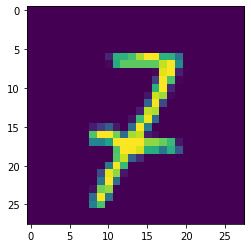

In [5]:
# Show example of image

# get random index
n = random.randint(0,59999)

# print label & show image
print("Label: %s" % (y_train[n]))
plt.imshow(X_train[n,:], interpolation='nearest')

## Data Preprocessing
In this section, we will:
1. Create two types of features space: flatten and as-is.
2. Normalize the value previously ranging from 0-255 to 0-1 to fasten the convergence time.

In [6]:
# Normalize the data

# print before normalize
print("Examlple value on pixels before normalization ") # the higher the darker
print(X_train[2,10,:])

# normalize
X_train = X_train / 255
X_test = X_test / 255

# print after normalize
print("Examlple value on pixels after normalization ")
print(X_train[2,10,:])

Examlple value on pixels before normalization 
[  0   0   0  46 245 163   0   0   0   0   0   0   0   0   0   0   0   0
   0 198 254  56   0   0   0   0   0   0]
Examlple value on pixels after normalization 
[0.         0.         0.         0.18039216 0.96078431 0.63921569
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.77647059 0.99607843 0.21960784 0.         0.
 0.         0.         0.         0.        ]


In [7]:
# Create flatten feature space

# reshape from 28x28 to 784
X_train_flat = X_train.reshape(-1,784) 
X_test_flat = X_test.reshape(-1, 784)

# reshape the 28x28 to 28x28x1 for input CNN
X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

# Check the final shape
X_train_flat.shape, X_train.shape, X_test_flat.shape, X_test.shape

((60000, 784), (60000, 28, 28, 1), (10000, 784), (10000, 28, 28, 1))

## Evaluation Function

In [8]:
def evaluate_performance(y_test, y_pred, dataset):
    accuracy = accuracy_score(y_test, y_pred)
    f1_macro = f1_score(y_test, y_pred, average='macro')
    f1_micro = f1_score(y_test, y_pred, average='micro')
    precision = precision_score(y_test, y_pred, average='micro')
    recall = recall_score(y_test, y_pred, average='micro')
    
    print("\nPerformance metrics on %s set" % dataset)    
    print("Accuracy on %s set: %f" % (dataset, accuracy))
    print("F1 macro on %s set: %f" % (dataset, f1_macro))
    print("F1 micro on %s set: %f" % (dataset, f1_micro))
    print("Precision micro on %s set: %f" % (dataset, precision))
    print("Recall micro on %s set: %f" % (dataset, recall))
    
    return accuracy, precision, recall, f1_micro, f1_macro

def print_timing(training_time, prediction_time):
    print("\nTraining time: %f s" % training_time)
    print("Prediction time: %f s" % prediction_time)
    
def track_performance_metrics(accuracy, precision, recall, f1_micro, f1_macro,
                              accuracy_train, precision_train, recall_train, f1_micro_train, f1_macro_train,
                              training_time, prediction_time):
    # performance test set
    mlflow.log_metric('accuracy', accuracy)
    mlflow.log_metric('f1_macro', f1_macro)
    mlflow.log_metric('f1_micro', f1_micro)
    mlflow.log_metric('precision', precision)
    mlflow.log_metric('recall', recall)

    # performance train set
    mlflow.log_metric('accuracy_train', accuracy_train)
    mlflow.log_metric('f1_macro_train', f1_macro_train)
    mlflow.log_metric('f1_micro_train', f1_micro_train)
    mlflow.log_metric('precision_train', precision_train)
    mlflow.log_metric('recall_train', recall_train)
    
    mlflow.log_metric('training_time', training_time)
    mlflow.log_metric('prediction_time', prediction_time)

## Create Experiment Id in MLflow

In [9]:
# create experiment id for tracking using mlflow
exp_id = mlflow.create_experiment("solving-mnist1")

## Modeling: Multi-class Logistic Regression

In [10]:
# Define model
logreg = LogisticRegression(random_state = 33) # use default hyperparameters

with mlflow.start_run(experiment_id = exp_id):
    
    mlflow.log_param('model', 'logistic_regression')

    # training model
    start_training = time.time()
    logreg.fit(X_train_flat, y_train)
    end_training = time.time()

    # predict the test set
    start_prediction = time.time()
    y_pred = logreg.predict(X_test_flat)
    end_prediction = time.time()
    
    # predict the train set
    y_pred_train = logreg.predict(X_train_flat)

    # Evaluate performance
    accuracy, precision, recall, f1_micro, f1_macro = evaluate_performance(y_test, y_pred, 'test')
    accuracy_train, precision_train, recall_train, f1_micro_train, f1_macro_train = evaluate_performance(y_train,
                                                                                                         y_pred_train,
                                                                                                         'train')
    training_time = end_training - start_training
    prediction_time = end_prediction - start_prediction
    print_timing(training_time, prediction_time)
    
    # Track performance metrics
    track_performance_metrics(accuracy, precision, recall, f1_micro, f1_macro,
                              accuracy_train, precision_train, recall_train, f1_micro_train, f1_macro_train,
                              training_time, prediction_time)


Performance metrics on test set
Accuracy on test set: 0.925800
F1 macro on test set: 0.924792
F1 micro on test set: 0.925800
Precision micro on test set: 0.925800
Recall micro on test set: 0.925800

Performance metrics on train set
Accuracy on train set: 0.935050
F1 macro on train set: 0.934227
F1 micro on train set: 0.935050
Precision micro on train set: 0.935050
Recall micro on train set: 0.935050

Training time: 9.372897 s
Prediction time: 0.017661 s


## Modeling: Random Forest

In [11]:
# Define model
rfc = RandomForestClassifier(random_state= 33) # use default hyperparameters

with mlflow.start_run(experiment_id = exp_id):
    
    mlflow.log_param('model', 'random_forest')
    
    # training model
    start_training = time.time()
    rfc.fit(X_train_flat, y_train)
    end_training = time.time()

    # predict the test set
    start_prediction = time.time()
    y_pred = rfc.predict(X_test_flat)
    end_prediction = time.time()

    # predict the train set
    y_pred_train = rfc.predict(X_train_flat)

    # Evaluate performance
    accuracy, precision, recall, f1_micro, f1_macro = evaluate_performance(y_test, y_pred, 'test')
    accuracy_train, precision_train, recall_train, f1_micro_train, f1_macro_train = evaluate_performance(y_train,
                                                                                                         y_pred_train,
                                                                                                         'train')
    training_time = end_training - start_training
    prediction_time = end_prediction - start_prediction
    print_timing(training_time, prediction_time)
    
    # Track performance metrics
    track_performance_metrics(accuracy, precision, recall, f1_micro, f1_macro,
                              accuracy_train, precision_train, recall_train, f1_micro_train, f1_macro_train,
                              training_time, prediction_time)


Performance metrics on test set
Accuracy on test set: 0.968600
F1 macro on test set: 0.968310
F1 micro on test set: 0.968600
Precision micro on test set: 0.968600
Recall micro on test set: 0.968600

Performance metrics on train set
Accuracy on train set: 1.000000
F1 macro on train set: 1.000000
F1 micro on train set: 1.000000
Precision micro on train set: 1.000000
Recall micro on train set: 1.000000

Training time: 35.693365 s
Prediction time: 0.384962 s


## Modeling: Multi Layer Perceptron (MLP)

In [12]:
# Define model
# We will use 1 hidden layers in this model and 384/256 units for each layers
# L1 regularization is applied to get faster convergence time in sparse dataset like MNIST

mlp_model = keras.Sequential([
    keras.layers.Dense(384, activation= 'relu'
                       , kernel_initializer= 'he_normal'
                       , kernel_regularizer= keras.regularizers.l1(0.00001)
                      ),
    keras.layers.Dense(256, activation= 'relu'
                       , kernel_initializer= 'he_normal'
                       , kernel_regularizer= keras.regularizers.l1(0.0001)
                      ),
    keras.layers.Dense(10)
])

# Compile model
mlp_model.compile(optimizer= 'adam',
                  loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics= ['accuracy'])

with mlflow.start_run(experiment_id = exp_id):
    
    mlflow.log_param('model', 'mlp')

    # training model
    start_training = time.time()
    mlp_model.fit(X_train_flat, y_train, epochs=5)
    end_training = time.time()

    # predict the test set
    start_prediction = time.time()
    y_pred_long = mlp_model.predict(X_test_flat)
    y_pred = np.argmax(y_pred_long, axis=1)
    end_prediction = time.time()

    # predict the train set
    y_pred_train_long = mlp_model.predict(X_train_flat)
    y_pred_train = np.argmax(y_pred_train_long, axis=1)

    # Evaluate performance
    accuracy, precision, recall, f1_micro, f1_macro = evaluate_performance(y_test, y_pred, 'test')
    accuracy_train, precision_train, recall_train, f1_micro_train, f1_macro_train = evaluate_performance(y_train,
                                                                                                         y_pred_train,
                                                                                                         'train')
    training_time = end_training - start_training
    prediction_time = end_prediction - start_prediction
    print_timing(training_time, prediction_time)
    
    # Track performance metrics
    track_performance_metrics(accuracy, precision, recall, f1_micro, f1_macro,
                              accuracy_train, precision_train, recall_train, f1_micro_train, f1_macro_train,
                              training_time, prediction_time)

Train on 60000 samples
Epoch 1/5
60000/60000 [==============================] - 20s 330us/sample - loss: 0.5458 - accuracy: 0.9402
Epoch 2/5
60000/60000 [==============================] - 19s 319us/sample - loss: 0.2701 - accuracy: 0.9691
Epoch 3/5
60000/60000 [==============================] - 20s 325us/sample - loss: 0.2027 - accuracy: 0.9762
Epoch 4/5
60000/60000 [==============================] - 21s 344us/sample - loss: 0.1652 - accuracy: 0.9802
Epoch 5/5
60000/60000 [==============================] - 19s 322us/sample - loss: 0.1417 - accuracy: 0.9832

Performance metrics on test set
Accuracy on test set: 0.975000
F1 macro on test set: 0.974875
F1 micro on test set: 0.975000
Precision micro on test set: 0.975000
Recall micro on test set: 0.975000

Performance metrics on train set
Accuracy on train set: 0.985267
F1 macro on train set: 0.985232
F1 micro on train set: 0.985267
Precision micro on train set: 0.985267
Recall micro on train set: 0.985267

Training time: 98.765327 s
Predi

## Modeling: Convolutional Neural Network (CNN)

In [13]:
# Define model
# The model is constructed by several layers
# We use relu activation and he initializer to get faster converge time
# The first layer is convolutional layer with 16 filter, 3x3 kernel size, 1 stride
# The second layer is the same with the first layer. They are supposed to capture feature maps from digit image.
# The third layer is pooling with maximum aggregation. It is used to reduce the size of feature maps.
# The fourth layer is convolutional layer for the result from maximum pooling.
# The next layer is dense neural network with 256 units, before feeding this layer with data,
# we need to flatten first the data
# The last layer / output layer is dense neural network with 10 units (the same with number of class)

cnn_model = keras.models.Sequential([
    keras.layers.Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=(28,28,1), # shape 28x28x1
                        kernel_initializer= 'he_normal'),
    keras.layers.Conv2D(16, kernel_size=(3, 3), activation='relu', 
                        kernel_initializer= 'he_normal'),
    keras.layers.MaxPooling2D(pool_size=(3, 3)),
    keras.layers.Conv2D(16, kernel_size=(3, 3), activation='relu', 
                        kernel_initializer= 'he_normal'),
    keras.layers.Flatten(),
    keras.layers.Dense(256, activation='relu', 
                       kernel_initializer= 'he_normal'),
    keras.layers.Dense(10, activation='softmax')
])

# Compile model
cnn_model.compile(optimizer= 'adam',
                  loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics= ['accuracy'])

with mlflow.start_run(experiment_id = exp_id):
    
    mlflow.log_param('model', 'cnn')

    # training model
    start_training = time.time()
    cnn_model.fit(X_train, y_train, epochs=5)
    end_training = time.time()

    # predict the test set
    start_prediction = time.time()
    y_pred_long = cnn_model.predict(X_test)
    y_pred = np.argmax(y_pred_long, axis=1)
    end_prediction = time.time()

    # predict the train set
    y_pred_train_long = mlp_model.predict(X_train_flat)
    y_pred_train = np.argmax(y_pred_train_long, axis=1)

    # Evaluate performance
    accuracy, precision, recall, f1_micro, f1_macro = evaluate_performance(y_test, y_pred, 'test')
    accuracy_train, precision_train, recall_train, f1_micro_train, f1_macro_train = evaluate_performance(y_train,
                                                                                                         y_pred_train,
                                                                                                         'train')
    training_time = end_training - start_training
    prediction_time = end_prediction - start_prediction
    print_timing(training_time, prediction_time)
    
    # Track performance metrics
    track_performance_metrics(accuracy, precision, recall, f1_micro, f1_macro,
                              accuracy_train, precision_train, recall_train, f1_micro_train, f1_macro_train,
                              training_time, prediction_time)

Train on 60000 samples
Epoch 1/5
60000/60000 [==============================] - 33s 543us/sample - loss: 1.5648 - accuracy: 0.8978
Epoch 2/5
60000/60000 [==============================] - 29s 487us/sample - loss: 1.4819 - accuracy: 0.9798
Epoch 3/5
60000/60000 [==============================] - 28s 463us/sample - loss: 1.4792 - accuracy: 0.9820
Epoch 4/5
60000/60000 [==============================] - 29s 477us/sample - loss: 1.4783 - accuracy: 0.9828
Epoch 5/5
60000/60000 [==============================] - 30s 495us/sample - loss: 1.4765 - accuracy: 0.9848

Performance metrics on test set
Accuracy on test set: 0.985300
F1 macro on test set: 0.985225
F1 micro on test set: 0.985300
Precision micro on test set: 0.985300
Recall micro on test set: 0.985300

Performance metrics on train set
Accuracy on train set: 0.985267
F1 macro on train set: 0.985232
F1 micro on train set: 0.985267
Precision micro on train set: 0.985267
Recall micro on train set: 0.985267

Training time: 147.970940 s
Pred

## Run MLflow tracking UI

In [14]:
!mlflow ui

/Users/ajisamudra/anaconda3/envs/experiment-tracking/lib/python3.6/site-packages/alembic/operations/base.py:94: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  spec = inspect.getargspec(fn)
/Users/ajisamudra/anaconda3/envs/experiment-tracking/lib/python3.6/site-packages/alembic/util/langhelpers.py:76: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  spec = inspect.getargspec(fn)
[2020-12-11 09:59:22 +0700] [6567] [INFO] Starting gunicorn 20.0.4
[2020-12-11 09:59:22 +0700] [6567] [INFO] Listening at: http://127.0.0.1:5000 (6567)
[2020-12-11 09:59:22 +0700] [6567] [INFO] Using worker: sync
[2020-12-11 09:59:22 +0700] [6570] [INFO] Booting worker with pid: 6570
^C

Aborted!
[2020-12-11 10:01:41 +0700] [6567] [INFO] Handling signal: int
[2020-12-11 10:01:41 +0700] [6570] [INFO] Worker exiting (pid: 6570)
